# Power spectral density (PSD) of NEEM CFA data for GI19.2 data
***
* Author: Yannick E. Heiser
* Email:  wfg813@alumni.ku.dk
* Last Update:   11th of May 2023
***

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from iminuit import Minuit 
from ExternalFunctions import Chi2Regression
plt.rcParams['axes.labelsize'] = 40
plt.rcParams['font.size'] = 30
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.rcParams['legend.fontsize'] = 25
plt.rcParams['axes.axisbelow'] = True
import sys
import glob
import os
from tkinter import Tcl
from os.path import join
from scipy.ndimage import gaussian_filter1d
from scipy.signal import welch
from scipy.interpolate import CubicSpline, PchipInterpolator
import matplotlib.ticker as ticker
!{sys.executable} -m pip install xlrd

### 1. Load CFA data

In [2]:
# Load interpolated CFA data
file_path = "/home/jovyan/work/PICE/ResearchGroups/Stratigraphy/Yannick 2022/Data_csv/CFA_interpolated/"

path = file_path + "CFA_interpolated.csv"
CFA_interp_slic = pd.read_csv(path)
CFA_interp_slic.head()

,Depth top (m),Cond (mikroS/cm),Na+ (ng/g),Ca++ (ng/g),Dust (#/mL) [SD>1.0],NH4+ (ng/g),NO3- (ng/g),H2O2 (ng/g),age (yr b2k)
0,2002.551,1.044638,35.386801,55.215085,12756.954682,1.126816,64.802555,NaN,71186.178182
1,2002.552,1.053359,34.908770,55.349388,12533.003895,1.146882,64.671126,NaN,71186.356364
2,2002.553,1.062309,34.420666,55.475033,12295.928952,1.166981,64.537724,NaN,71186.534545
3,2002.554,1.071514,33.925007,55.593180,12045.890426,1.187068,64.403140,NaN,71186.712727
4,2002.555,1.081003,33.424313,55.704991,11783.048888,1.207099,64.268160,NaN,71186.890909


### 2. Create PSD and perform linear fits for GI19.2 bags 3642-3647

yearly layer thickness:  5.85 mm


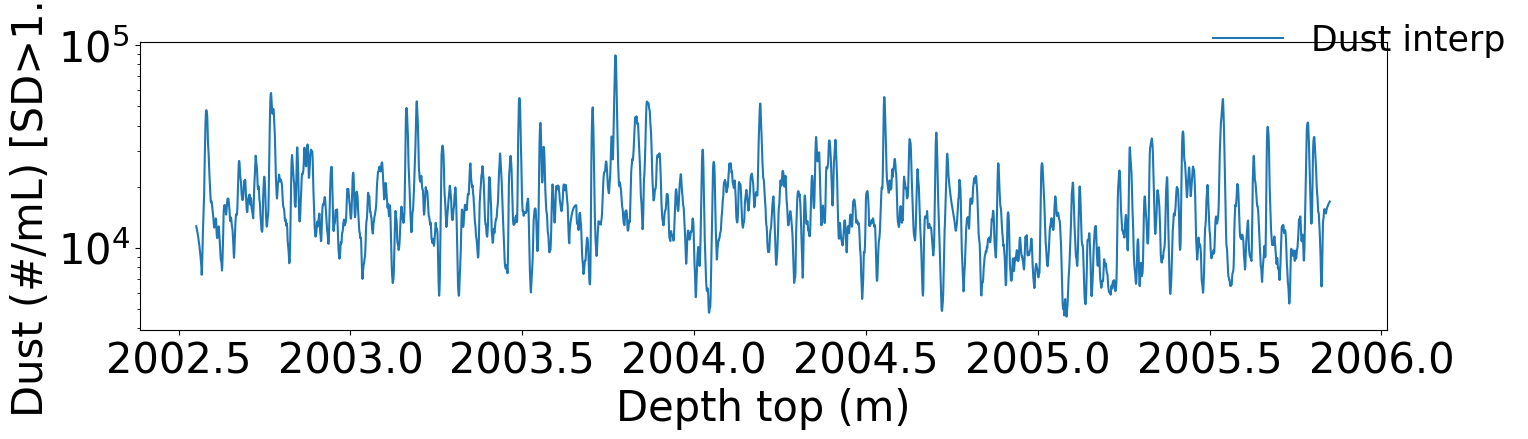

In [3]:
# Only look at staidial
CFA_interp_stadial = CFA_interp_slic[CFA_interp_slic["Depth top (m)"]<(3647)*0.55]
CFA_interp_stadial = CFA_interp_stadial[CFA_interp_stadial["Depth top (m)"]>(3642-1)*0.55]
layer_thickness = (CFA_interp_stadial["Depth top (m)"].iloc[-1]-CFA_interp_stadial["Depth top (m)"].iloc[0])/(CFA_interp_stadial["age (yr b2k)"].iloc[-1]-CFA_interp_stadial["age (yr b2k)"].iloc[0])
print("yearly layer thickness: ",round(layer_thickness*1000,2),"mm")


# Plot interpolated and original data
fig, ax = plt.subplots(figsize=(16, 5))
ax.semilogy(CFA_interp_stadial["Depth top (m)"], CFA_interp_stadial["Dust (#/mL) [SD>1.0]"], '-',label="Dust interp",alpha=1)
ax.set_xlabel('Depth top (m)')
ax.set_ylabel('Dust (#/mL) [SD>1.0]')
ax.legend(loc="best", bbox_to_anchor= (0.85, 0.9), ncol=1,
            borderaxespad=0, frameon=False)

plt.tight_layout()
plt.show()

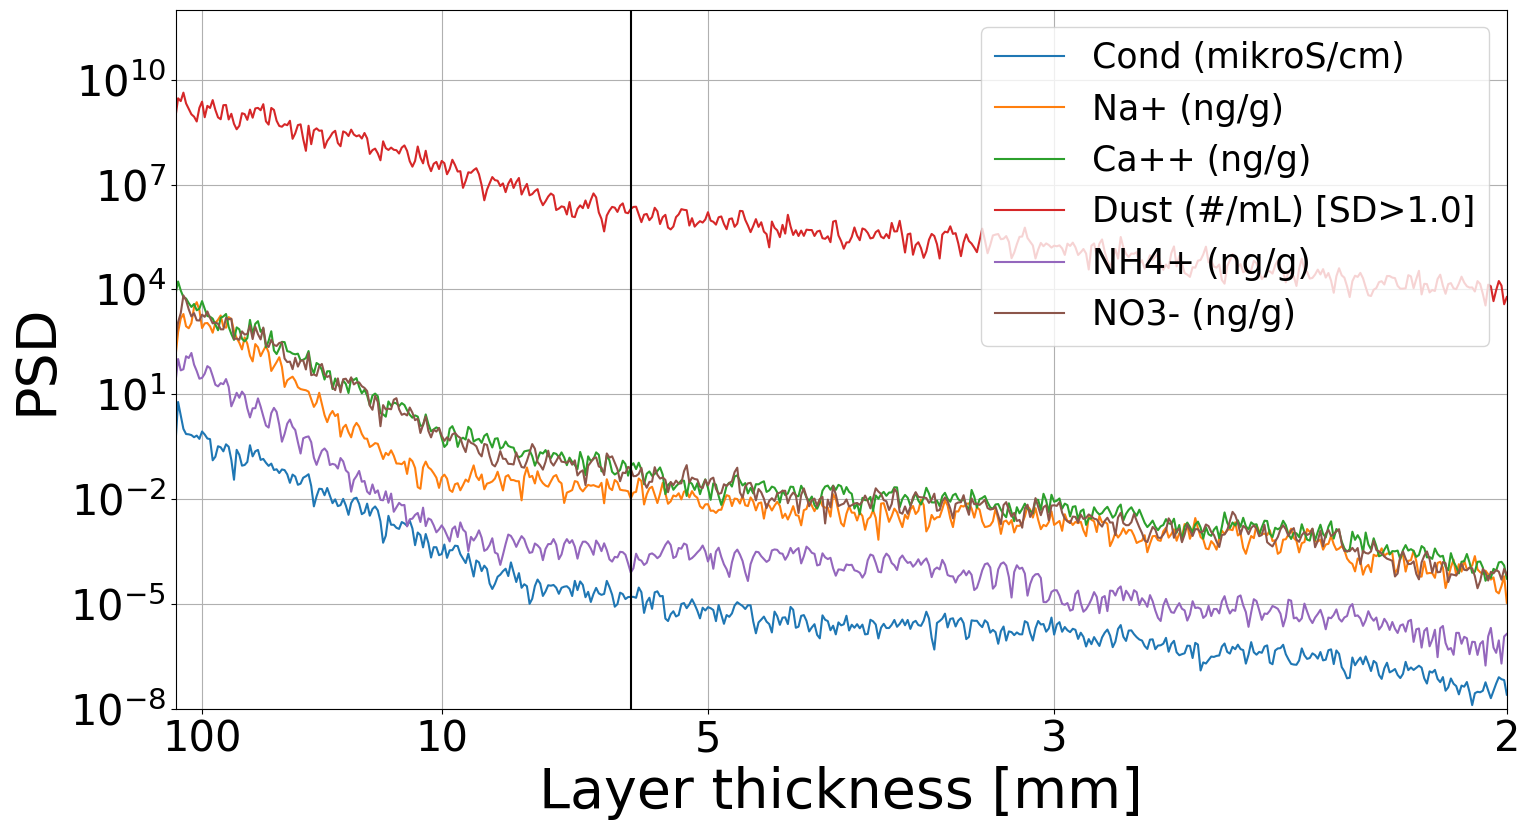

In [8]:
# Plot PSD
fs = 1 # sampling frequency in [1/mm]
fig, ax = plt.subplots(figsize=(16, 9))
for key in CFA_interp_stadial.keys()[1:-2]:
    f, Pxx = welch(CFA_interp_stadial[key],fs,nperseg = 1000)
    ax.semilogy(f, Pxx,label=key)
#ax.set_ylim(ax.get_ylim()[0],ax.get_ylim()[1])
ax.set_ylim(1e-8,1e12)
ax.vlines(1/layer_thickness/1000,ymin=1e-8,ymax=1e12,color="black")
ax.set_xlim(0.0001,0.5)
ax.set_xticks([1/100,0.1,0.2,0.33,0.5])
ax.set_xticklabels([100,int(1/0.1),int(1/0.2),int(1/0.33),int(1/0.5)])
ax.set_xlabel('Layer thickness [mm]')
ax.set_ylabel('PSD')
ax.legend(loc="upper right")
ax.grid()
fig.tight_layout()
fig.savefig("Plots/17_CFA_PSD_GI19.png",dpi=100)
fig.show()

In [5]:
# Create dict containing desired resolutions in mm
resolution_mm = {}

sampling resolution (Cond (mikroS/cm)):  8.08  +  0.79 mm
	 fit signal interval:  0.0 < f <  0.14 1/mm
	 fit signal interval:  0.2 < f <  0.33 1/mm


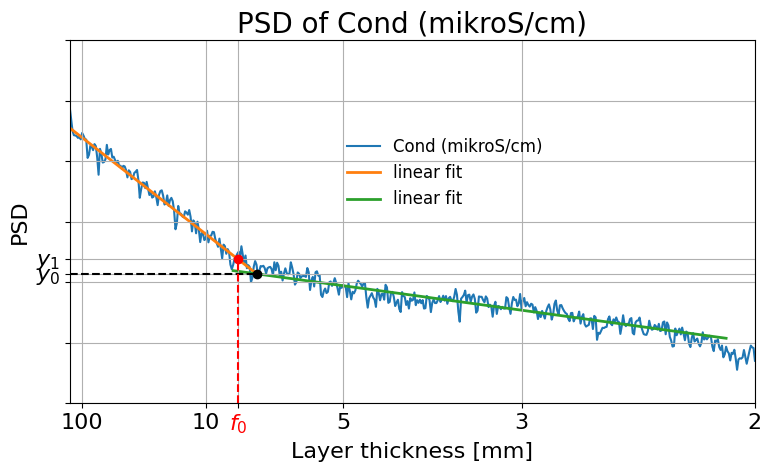

In [6]:
# Plot PSD of Conductivity
fs = 1 # sampling frequency in [1/mm]
for key in CFA_interp_stadial.keys()[1:2]:
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.ticklabel_format(axis='y', style='sci', useOffset=False)    
    ax.grid()
    f, Pxx = welch(CFA_interp_stadial[key],fs,nperseg = 1000)
    a1,b1=np.polyfit(f[:120],np.log(Pxx[:120]),1)
    a2,b2=np.polyfit(f[150:450],np.log(Pxx[150:450]),1)
    intersection_f = (b1-b2)/(a2-a1)
    intersection_y = a1*intersection_f+b1
    ax.semilogy(f, Pxx,label=key,zorder=0)
    ax.plot(f[:140],np.exp(a1*f[:140]+b1),label="linear fit",zorder=0,lw=2)
    ax.plot(f[120:480],np.exp(a2*f[120:480]+b2),label="linear fit",zorder=0,lw=2)
    ax.scatter(intersection_f,np.exp(intersection_y),c="black",alpha=1,marker="o",zorder=1)
    ax.axhline(y=np.exp(intersection_y), xmin=0, xmax=intersection_f/0.5,ls="--",c="black")
    y2 = 3*np.exp(intersection_y)
    f_final = (np.log(y2)-b1)/a1
    ax.scatter(f_final,y2,c="red",alpha=1,marker="o")
    ax.axvline(x=f_final, ymax=0.4,ls="--",c="red")
    f_err_mm = abs(1/f_final-1/intersection_f)
    print("sampling resolution ({}): ".format(key),round(1/f_final,2)," + ",round(f_err_mm,2),"mm")
    print("\t fit signal interval: ",round(f[0],2),"< f < ", round(f[143],2),"1/mm")
    print("\t fit signal interval: ",round(f[200],2),"< f < ", round(f[334],2),"1/mm")
    resolution_mm[key] = round(1/f_final,2)
    ax.set_xlim(0.001,0.5)
    ax.set_xticks([f_final,1/100,0.1,0.2,0.33,0.5])
    ax.set_xticklabels([r"$f_{0}$",100,int(1/0.1),int(1/0.2),int(1/0.33),int(1/0.5)])
    xticks = ax.get_xticks()
    yticks = ax.get_yticks()[1:-1]
    yticks = np.concatenate((yticks,np.array([np.exp(intersection_y),y2])))
    ax.set_yticks(yticks)
    y_labels = np.ones(len(yticks[:-2]),dtype="U8")
    y_labels[:] = ""
    ylabels = np.concatenate((y_labels,np.array(["$y_0$","$y_1$"])))
    y_color = np.ones(len(yticks[:-2]),dtype="U8")
    y_color[:] = "black"
    y_color = np.concatenate((y_color,np.array(["black","black"])))
    ax.set_yticklabels(ylabels)
    x_color = np.ones(len(xticks[:-1]),dtype="U8")
    x_color[:] = "black"
    x_color = np.concatenate((np.array(["red"]),x_color))
    [t.set_color(i) for (i,t) in zip(y_color,ax.yaxis.get_ticklabels())]
    [t.set_color(i) for (i,t) in zip(x_color,ax.xaxis.get_ticklabels())]
    ax.set_xlabel('Layer thickness [mm]')
    ax.set_ylabel('PSD')
    ax.set_title("PSD of {}".format(key))
    ax.legend(bbox_to_anchor= (0.7, 0.75), ncol=1,
                borderaxespad=0, frameon=False)
    fig.tight_layout()
    fig.show()

sampling resolution (Na+ (ng/g)):  12.44  +  1.1 mm
	 fit signal interval:  0.0 < f <  0.08 1/mm
	 fit signal interval:  0.11 < f <  0.43 1/mm


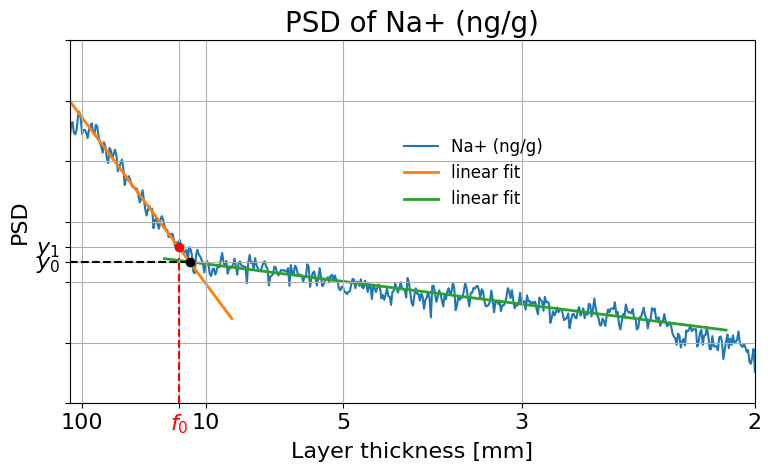

In [7]:
# Plot PSD of Na+
fs = 1 # sampling frequency in [1/mm]
for key in CFA_interp_stadial.keys()[2:3]:
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.ticklabel_format(axis='y', style='sci', useOffset=False)    
    ax.grid()
    f, Pxx = welch(CFA_interp_stadial[key],fs,nperseg = 1000)
    a1,b1=np.polyfit(f[12:80],np.log(Pxx[12:80]),1)
    a2,b2=np.polyfit(f[110:430],np.log(Pxx[110:430]),1)
    intersection_f = (b1-b2)/(a2-a1)
    intersection_y = a1*intersection_f+b1
    ax.semilogy(f, Pxx,label=key,zorder=0)
    ax.plot(f[0:120],np.exp(a1*f[0:120]+b1),label="linear fit",zorder=0,lw=2)
    ax.plot(f[70:480],np.exp(a2*f[70:480]+b2),label="linear fit",zorder=0,lw=2)
    ax.scatter(intersection_f,np.exp(intersection_y),c="black",alpha=1,marker="o",zorder=1)
    ax.axhline(y=np.exp(intersection_y), xmin=0, xmax=intersection_f/0.5,ls="--",c="black")
    y2 = 3*np.exp(intersection_y)
    f_final = (np.log(y2)-b1)/a1
    ax.scatter(f_final,y2,c="red",alpha=1,marker="o")
    ax.axvline(x=f_final, ymax=0.4,ls="--",c="red")
    f_err_mm = abs(1/f_final-1/intersection_f)
    print("sampling resolution ({}): ".format(key),round(1/f_final,2)," + ",round(f_err_mm,2),"mm")
    print("\t fit signal interval: ",round(f[0],2),"< f < ", round(f[80],2),"1/mm")
    print("\t fit signal interval: ",round(f[110],2),"< f < ", round(f[430],2),"1/mm")
    resolution_mm[key] = round(1/f_final,2)
    ax.set_xlim(0.001,0.5)
    ax.set_xticks([f_final,1/100,0.1,0.2,0.33,0.5])
    ax.set_xticklabels([r"$f_{0}$",100,int(1/0.1),int(1/0.2),int(1/0.33),int(1/0.5)])
    xticks = ax.get_xticks()
    yticks = ax.get_yticks()[1:-1]
    yticks = np.concatenate((yticks,np.array([np.exp(intersection_y),y2])))
    ax.set_yticks(yticks)
    y_labels = np.ones(len(yticks[:-2]),dtype="U8")
    y_labels[:] = ""
    ylabels = np.concatenate((y_labels,np.array(["$y_0$","$y_1$"])))
    y_color = np.ones(len(yticks[:-2]),dtype="U8")
    y_color[:] = "black"
    y_color = np.concatenate((y_color,np.array(["black","black"])))
    ax.set_yticklabels(ylabels)
    x_color = np.ones(len(xticks[:-1]),dtype="U8")
    x_color[:] = "black"
    x_color = np.concatenate((np.array(["red"]),x_color))
    [t.set_color(i) for (i,t) in zip(y_color,ax.yaxis.get_ticklabels())]
    [t.set_color(i) for (i,t) in zip(x_color,ax.xaxis.get_ticklabels())]
    ax.set_xlabel('Layer thickness [mm]')
    ax.set_ylabel('PSD')
    ax.set_title("PSD of {}".format(key))
    ax.legend(bbox_to_anchor= (0.7, 0.75), ncol=1,
                borderaxespad=0, frameon=False)
    fig.tight_layout()
    fig.show()

sampling resolution (Ca++ (ng/g)):  9.14  +  0.92 mm
	 fit signal interval:  0.0 < f <  0.12 1/mm
	 fit signal interval:  0.12 < f <  0.42 1/mm
118


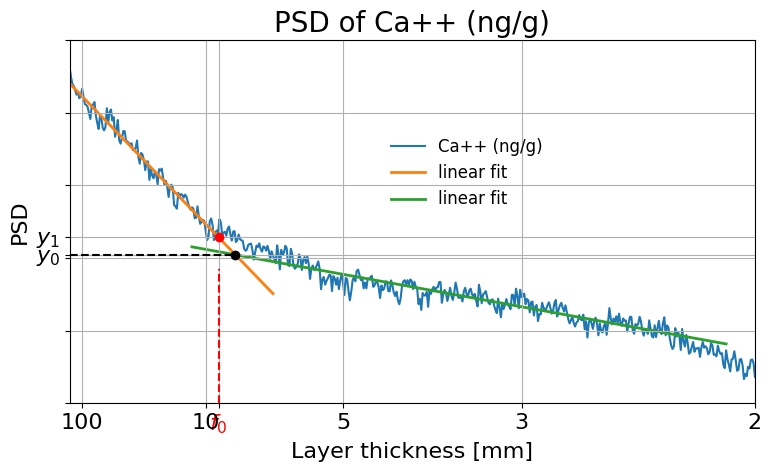

In [8]:
# Plot PSD of Ca2+
fs = 1 # sampling frequency in [1/mm]
for key in CFA_interp_stadial.keys()[3:4]:
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.ticklabel_format(axis='y', style='sci', useOffset=False)    
    ax.grid()
    f, Pxx = welch(CFA_interp_stadial[key],fs,nperseg = 1000)
    a1,b1=np.polyfit(f[:100],np.log(Pxx[:100]),1)
    a2,b2=np.polyfit(f[140:450],np.log(Pxx[140:450]),1)
    intersection_f = (b1-b2)/(a2-a1)
    intersection_y = a1*intersection_f+b1
    ax.semilogy(f, Pxx,label=key,zorder=0)
    ax.plot(f[:150],np.exp(a1*f[:150]+b1),label="linear fit",zorder=0,lw=2)
    ax.plot(f[90:480],np.exp(a2*f[90:480]+b2),label="linear fit",zorder=0,lw=2)
    ax.scatter(intersection_f,np.exp(intersection_y),c="black",alpha=1,marker="o",zorder=1)
    ax.axhline(y=np.exp(intersection_y), xmin=0, xmax=intersection_f/0.5,ls="--",c="black")
    y2 = 3*np.exp(intersection_y)
    f_final = (np.log(y2)-b1)/a1
    ax.scatter(f_final,y2,c="red",alpha=1,marker="o")
    ax.axvline(x=f_final, ymax=y2,ls="--",c="red")
    f_err_mm = abs(1/f_final-1/intersection_f)
    print("sampling resolution ({}): ".format(key),round(1/f_final,2)," + ",round(f_err_mm,2),"mm")
    print("\t fit signal interval: ",round(f[0],2),"< f < ", round(f[120],2),"1/mm")
    print("\t fit signal interval: ",round(f[125],2),"< f < ", round(f[420],2),"1/mm")
    resolution_mm[key] = round(1/f_final,2)
    ax.set_xlim(0.001,0.5)
    ax.set_xticks([f_final,1/100,0.1,0.2,0.33,0.5])
    ax.set_xticklabels([r"$f_{0}$",100,int(1/0.1),int(1/0.2),int(1/0.33),int(1/0.5)])
    xticks = ax.get_xticks()
    yticks = ax.get_yticks()[1:-1]
    yticks = np.concatenate((yticks,np.array([np.exp(intersection_y),y2])))
    ax.set_yticks(yticks)
    y_labels = np.ones(len(yticks[:-2]),dtype="U8")
    y_labels[:] = ""
    ylabels = np.concatenate((y_labels,np.array(["$y_0$","$y_1$"])))
    y_color = np.ones(len(yticks[:-2]),dtype="U8")
    y_color[:] = "black"
    y_color = np.concatenate((y_color,np.array(["black","black"])))
    ax.set_yticklabels(ylabels)
    x_color = np.ones(len(xticks[:-1]),dtype="U8")
    x_color[:] = "black"
    x_color = np.concatenate((np.array(["red"]),x_color))
    [t.set_color(i) for (i,t) in zip(y_color,ax.yaxis.get_ticklabels())]
    [t.set_color(i) for (i,t) in zip(x_color,ax.xaxis.get_ticklabels())]
    ax.set_xlabel('Layer thickness [mm]')
    ax.set_ylabel('PSD')
    ax.set_title("PSD of {}".format(key))
    ax.legend(bbox_to_anchor= (0.7, 0.75), ncol=1,
                borderaxespad=0, frameon=False)
    fig.tight_layout()
    fig.show()
print(len(f[f<1/8.48]))

sampling resolution (Dust (#/mL) [SD>1.0]):  7.2  +  1.0 mm
	 fit signal interval:  0.0 < f <  0.14 1/mm
	 fit signal interval:  0.2 < f <  0.33 1/mm


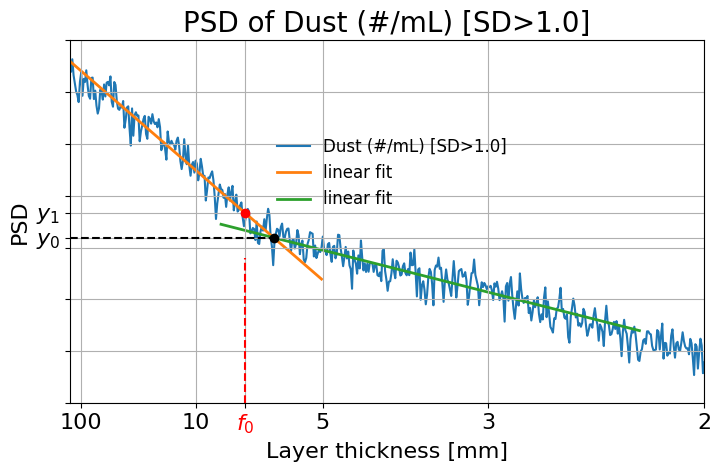

In [9]:
# Plot PSD of Dust
fs = 1 # sampling frequency in [1/mm]
for key in CFA_interp_stadial.keys()[4:5]:
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.ticklabel_format(axis='y', style='sci', useOffset=False)    
    ax.grid(axis="both")
    f, Pxx = welch(CFA_interp_stadial[key],fs,nperseg = 1000)
    a1,b1=np.polyfit(f[20:150],np.log(Pxx[20:150]),1)
    a2,b2=np.polyfit(f[180:400],np.log(Pxx[180:400]),1)
    intersection_f = (b1-b2)/(a2-a1)
    intersection_y = a1*intersection_f+b1
    ax.semilogy(f, Pxx,label=key,zorder=0)
    ax.plot(f[0:200],np.exp(a1*f[0:200]+b1),label="linear fit",zorder=0,lw=2)
    ax.plot(f[120:450],np.exp(a2*f[120:450]+b2),label="linear fit",zorder=0,lw=2)
    ax.scatter(intersection_f,np.exp(intersection_y),c="black",alpha=1,marker="o",zorder=1)
    ax.axhline(y=np.exp(intersection_y), xmin=0, xmax=intersection_f/0.5,ls="--",c="black")
    y2 = 3*np.exp(intersection_y)
    f_final = (np.log(y2)-b1)/a1
    ax.scatter(f_final,y2,c="red",alpha=1,marker="o")
    ax.axvline(x=f_final, ymax=0.4,ls="--",c="red")
    f_err_mm = abs(1/f_final-1/intersection_f)
    print("sampling resolution ({}): ".format(key),round(1/f_final,2)," + ",round(f_err_mm,2),"mm")
    print("\t fit signal interval: ",round(f[0],2),"< f < ", round(f[135],2),"1/mm")
    print("\t fit signal interval: ",round(f[200],2),"< f < ", round(f[334],2),"1/mm")
    resolution_mm[key] = round(1/f_final,2)
    ax.set_xlim(0.001,0.5)
    ax.set_xticks([f_final,1/100,0.1,0.2,0.33,0.5])
    ax.set_xticklabels([r"$f_{0}$",100,int(1/0.1),int(1/0.2),int(1/0.33),int(1/0.5)])
    ax.yaxis.set_tick_params(which='minor', bottom=False)
    xticks = ax.get_xticks()
    yticks = ax.get_yticks()[1:-1]
    yticks = np.concatenate((yticks,np.array([np.exp(intersection_y),y2])))
    ax.set_yticks(yticks)
    y_labels = np.ones(len(yticks[:-2]),dtype="U8")
    y_labels[:] = ""
    ylabels = np.concatenate((y_labels,np.array(["$y_0$","$y_1$"])))
    y_color = np.ones(len(yticks[:-2]),dtype="U8")
    y_color[:] = "black"
    y_color = np.concatenate((y_color,np.array(["black","black"])))
    ax.set_yticklabels(ylabels)
    x_color = np.ones(len(xticks[:-1]),dtype="U8")
    x_color[:] = "black"
    x_color = np.concatenate((np.array(["red"]),x_color))
    [t.set_color(i) for (i,t) in zip(y_color,ax.yaxis.get_ticklabels())]
    [t.set_color(i) for (i,t) in zip(x_color,ax.xaxis.get_ticklabels())]
    ax.set_xlabel('Layer thickness [mm]')
    ax.set_ylabel('PSD')
    ax.set_title("PSD of {}".format(key))
    ax.legend(bbox_to_anchor= (0.7, 0.75), ncol=1,
                borderaxespad=0, frameon=False)
    fig.tight_layout()
    fig.show()

sampling resolution (NH4+ (ng/g)):  10.6  +  0.95 mm
	 fit signal interval:  0.0 < f <  0.14 1/mm
	 fit signal interval:  0.2 < f <  0.33 1/mm


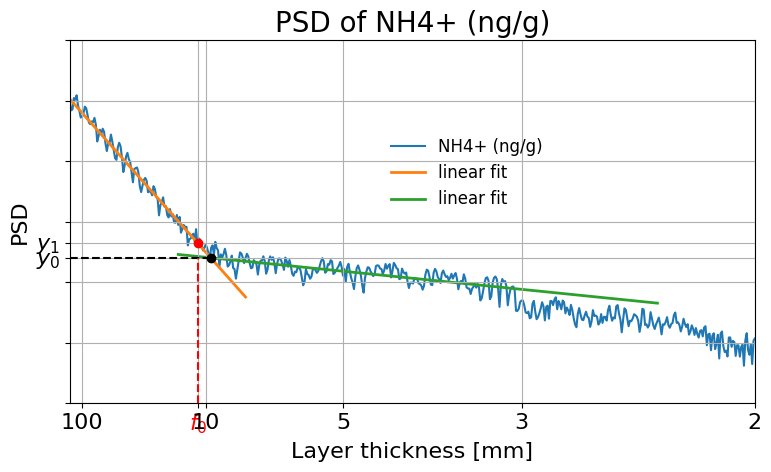

In [10]:
# Plot PSD of NH4+
fs = 1 # sampling frequency in [1/mm]
for key in CFA_interp_stadial.keys()[5:6]:
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.ticklabel_format(axis='y', style='sci', useOffset=False)    
    ax.grid(axis="both")
    f, Pxx = welch(CFA_interp_stadial[key],fs,nperseg = 1000)
    a1,b1=np.polyfit(f[0:100],np.log(Pxx[0:100]),1)
    a2,b2=np.polyfit(f[120:330],np.log(Pxx[120:330]),1)
    intersection_f = (b1-b2)/(a2-a1)
    intersection_y = a1*intersection_f+b1
    ax.semilogy(f, Pxx,label=key,zorder=0)
    ax.plot(f[0:130],np.exp(a1*f[0:130]+b1),label="linear fit",zorder=0,lw=2)
    ax.plot(f[80:430],np.exp(a2*f[80:430]+b2),label="linear fit",zorder=0,lw=2)
    ax.scatter(intersection_f,np.exp(intersection_y),c="black",alpha=1,marker="o",zorder=1)
    ax.axhline(y=np.exp(intersection_y), xmin=0, xmax=intersection_f/0.5,ls="--",c="black")
    y2 = 3*np.exp(intersection_y)
    f_final = (np.log(y2)-b1)/a1
    ax.scatter(f_final,y2,c="red",alpha=1,marker="o")
    ax.axvline(x=f_final, ymax=0.4,ls="--",c="red")
    f_err_mm = abs(1/f_final-1/intersection_f)
    print("sampling resolution ({}): ".format(key),round(1/f_final,2)," + ",round(f_err_mm,2),"mm")
    print("\t fit signal interval: ",round(f[0],2),"< f < ", round(f[135],2),"1/mm")
    print("\t fit signal interval: ",round(f[200],2),"< f < ", round(f[334],2),"1/mm")
    resolution_mm[key] = round(1/f_final,2)
    ax.set_xlim(0.001,0.5)
    ax.set_xticks([f_final,1/100,0.1,0.2,0.33,0.5])
    ax.set_xticklabels([r"$f_{0}$",100,int(1/0.1),int(1/0.2),int(1/0.33),int(1/0.5)])
    ax.yaxis.set_tick_params(which='minor', bottom=False)
    xticks = ax.get_xticks()
    yticks = ax.get_yticks()[1:-1]
    yticks = np.concatenate((yticks,np.array([np.exp(intersection_y),y2])))
    ax.set_yticks(yticks)
    y_labels = np.ones(len(yticks[:-2]),dtype="U8")
    y_labels[:] = ""
    ylabels = np.concatenate((y_labels,np.array(["$y_0$","$y_1$"])))
    y_color = np.ones(len(yticks[:-2]),dtype="U8")
    y_color[:] = "black"
    y_color = np.concatenate((y_color,np.array(["black","black"])))
    ax.set_yticklabels(ylabels)
    x_color = np.ones(len(xticks[:-1]),dtype="U8")
    x_color[:] = "black"
    x_color = np.concatenate((np.array(["red"]),x_color))
    [t.set_color(i) for (i,t) in zip(y_color,ax.yaxis.get_ticklabels())]
    [t.set_color(i) for (i,t) in zip(x_color,ax.xaxis.get_ticklabels())]
    ax.set_xlabel('Layer thickness [mm]')
    ax.set_ylabel('PSD')
    ax.set_title("PSD of {}".format(key))
    ax.legend(bbox_to_anchor= (0.7, 0.75), ncol=1,
                borderaxespad=0, frameon=False)
    fig.tight_layout()
    fig.show()

sampling resolution (NO3- (ng/g)):  9.0  +  0.94 mm
	 fit signal interval:  0.0 < f <  0.14 1/mm
	 fit signal interval:  0.2 < f <  0.33 1/mm


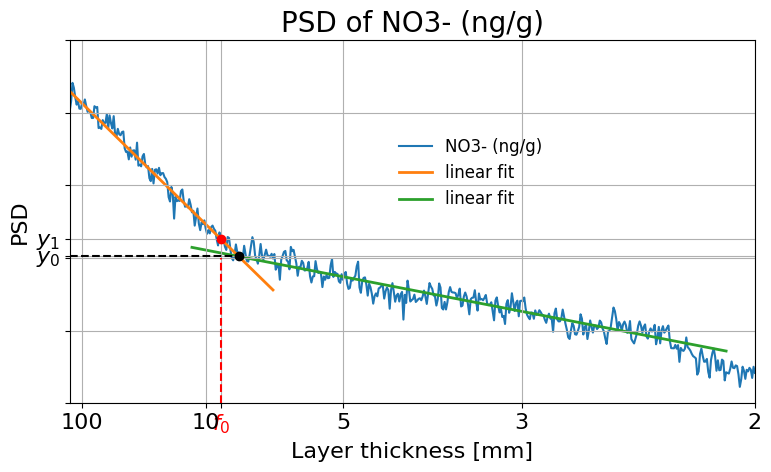

In [11]:
# Plot PSD of N03-
fs = 1 # sampling frequency in [1/mm]
for key in CFA_interp_stadial.keys()[6:7]:
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.ticklabel_format(axis='y', style='sci', useOffset=False)    
    ax.grid(axis="both")
    f, Pxx = welch(CFA_interp_stadial[key],fs,nperseg = 1000)
    a1,b1=np.polyfit(f[0:110],np.log(Pxx[0:110]),1)
    a2,b2=np.polyfit(f[130:435],np.log(Pxx[130:435]),1)
    intersection_f = (b1-b2)/(a2-a1)
    intersection_y = a1*intersection_f+b1
    ax.semilogy(f, Pxx,label=key,zorder=0)
    ax.plot(f[0:150],np.exp(a1*f[0:150]+b1),label="linear fit",zorder=0,lw=2)
    ax.plot(f[90:480],np.exp(a2*f[90:480]+b2),label="linear fit",zorder=0,lw=2)
    ax.scatter(intersection_f,np.exp(intersection_y),c="black",alpha=1,marker="o",zorder=1)
    ax.axhline(y=np.exp(intersection_y), xmin=0, xmax=intersection_f/0.5,ls="--",c="black")
    y2 = 3*np.exp(intersection_y)
    f_final = (np.log(y2)-b1)/a1
    ax.scatter(f_final,y2,c="red",alpha=1,marker="o")
    ax.axvline(x=f_final, ymax=0.4,ls="--",c="red")
    f_err_mm = abs(1/f_final-1/intersection_f)
    print("sampling resolution ({}): ".format(key),round(1/f_final,2)," + ",round(f_err_mm,2),"mm")
    print("\t fit signal interval: ",round(f[0],2),"< f < ", round(f[135],2),"1/mm")
    print("\t fit signal interval: ",round(f[200],2),"< f < ", round(f[334],2),"1/mm")
    resolution_mm[key] = round(1/f_final,2)
    ax.set_xlim(0.001,0.5)
    ax.set_xticks([f_final,1/100,0.1,0.2,0.33,0.5])
    ax.set_xticklabels([r"$f_{0}$",100,int(1/0.1),int(1/0.2),int(1/0.33),int(1/0.5)])
    ax.yaxis.set_tick_params(which='minor', bottom=False)
    xticks = ax.get_xticks()
    yticks = ax.get_yticks()[1:-1]
    yticks = np.concatenate((yticks,np.array([np.exp(intersection_y),y2])))
    ax.set_yticks(yticks)
    y_labels = np.ones(len(yticks[:-2]),dtype="U8")
    y_labels[:] = ""
    ylabels = np.concatenate((y_labels,np.array(["$y_0$","$y_1$"])))
    y_color = np.ones(len(yticks[:-2]),dtype="U8")
    y_color[:] = "black"
    y_color = np.concatenate((y_color,np.array(["black","black"])))
    ax.set_yticklabels(ylabels)
    x_color = np.ones(len(xticks[:-1]),dtype="U8")
    x_color[:] = "black"
    x_color = np.concatenate((np.array(["red"]),x_color))
    [t.set_color(i) for (i,t) in zip(y_color,ax.yaxis.get_ticklabels())]
    [t.set_color(i) for (i,t) in zip(x_color,ax.xaxis.get_ticklabels())]
    ax.set_xlabel('Layer thickness [mm]')
    ax.set_ylabel('PSD')
    ax.set_title("PSD of {}".format(key))
    ax.legend(bbox_to_anchor= (0.7, 0.75), ncol=1,
                borderaxespad=0, frameon=False)
    fig.tight_layout()
    fig.show()

### 2. PSD of stadial xLASM grain size

In [62]:
resolution_mm

{'Cond (mikroS/cm)': 8.08,
 'Na+ (ng/g)': 12.44,
 'Ca++ (ng/g)': 9.14,
 'Dust (#/mL) [SD>1.0]': 7.2,
 'NH4+ (ng/g)': 10.6,
 'NO3- (ng/g)': 9.0}

In [35]:
resolution_mm = {"8.44": 8.44, "8.58": 8.58,"10": 10}
df_sizes = {}
file_path = "/home/jovyan/work/PICE/ResearchGroups/Stratigraphy/Yannick 2022/Data_csv/grain_sizes_depth/"

for key in resolution_mm.keys():
    print(key)
    path = file_path + "grain_data_interp_{}mm.csv".format(resolution_mm[key])
    df_sizes[key] = pd.read_csv(path)
df_sizes["8.58"].head()

8.44
8.58
10


,depth[m],equivalent_diameter[px],grain_size[px]
0,2002.5525,305.580018,2.431269e+06
1,2002.5535,313.962910,2.601287e+06
2,2002.5545,306.918161,2.484274e+06
3,2002.5555,312.215345,2.554894e+06
4,2002.5565,313.779988,2.633956e+06


In [38]:
# Only stadial
df_sizes_stadial = {}
for res in df_sizes.keys():
    df_sizes_stadial[res] = df_sizes[res][df_sizes[res]["depth[m]"]<(3659)*0.55]
    df_sizes_stadial[res] = df_sizes_stadial[res][df_sizes_stadial[res]["depth[m]"]>(3655-1)*0.55]

Index(['depth[m]', 'equivalent_diameter[px]', 'grain_size[px]'], dtype='object')

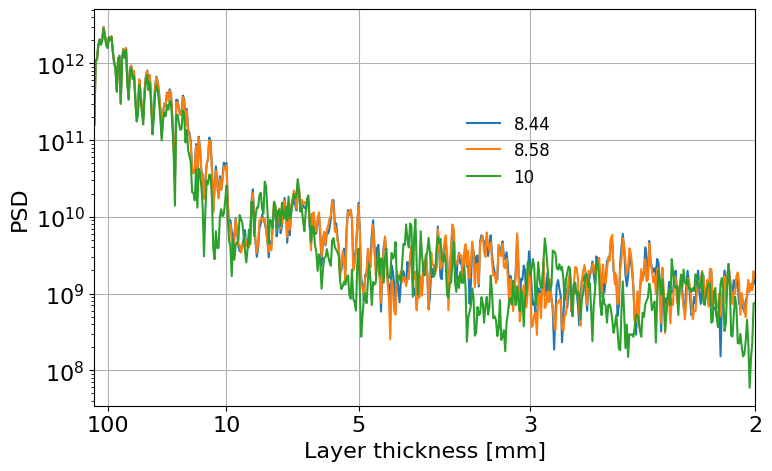

In [41]:
# Plot PSD of stadial xLASM
fs = 1 # sampling frequency in [1/mm]
fig, ax = plt.subplots(figsize=(8, 5))
for res in df_sizes_stadial.keys():
    f, Pxx = welch(df_sizes_stadial[res]["grain_size[px]"],fs,nperseg = 1000)
    ax.semilogy(f, Pxx,label=res)
ax.set_xlim(0.0001,0.5)
ax.set_xticks([1/100,0.1,0.2,0.33,0.5])
ax.set_xticklabels([100,int(1/0.1),int(1/0.2),int(1/0.33),int(1/0.5)])
ax.set_xlabel('Layer thickness [mm]')
ax.set_ylabel('PSD')
ax.legend(bbox_to_anchor= (0.7, 0.75), ncol=1,
            borderaxespad=0, frameon=False)
ax.grid()
fig.tight_layout()
fig.show()

### 5. Compare PSD of xLASM grain sizes and Dust/Ca2+

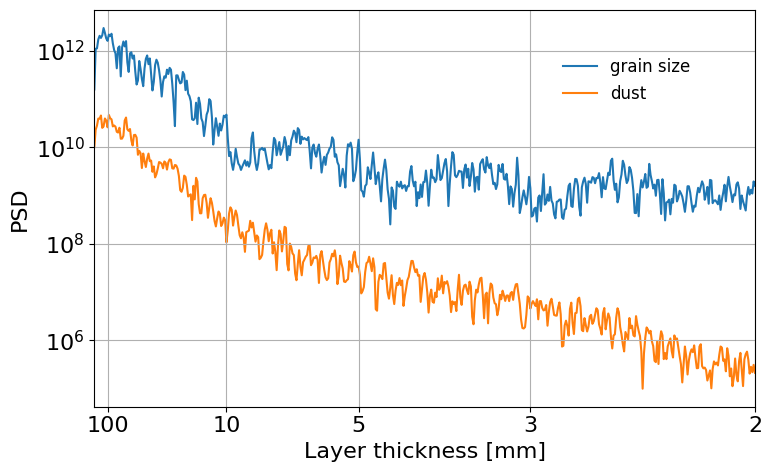

In [44]:
# Plot PSD of stadial xLASM grain sizes and Dust
fs = 1 # sampling frequency in [1/mm]
fig, ax = plt.subplots(figsize=(8, 5))
f, Pxx = welch(df_sizes_stadial["8.58"]["grain_size[px]"],fs,nperseg = 1000)
ax.semilogy(f, Pxx,label="grain size")
f, Pxx = welch(CFA_interp_stadial["Dust (#/mL) [SD>1.0]"],fs,nperseg = 1000)
ax.semilogy(f, Pxx,label="dust",zorder=0)
ax.set_xlim(0.0001,0.5)
ax.set_xticks([1/100,0.1,0.2,0.33,0.5])
ax.set_xticklabels([100,int(1/0.1),int(1/0.2),int(1/0.33),int(1/0.5)])
ax.set_xlabel('Layer thickness [mm]')
ax.set_ylabel('PSD')
ax.legend(bbox_to_anchor= (0.7, 0.75), ncol=1,
            borderaxespad=0, frameon=False)
ax.grid()
fig.tight_layout()
fig.show()

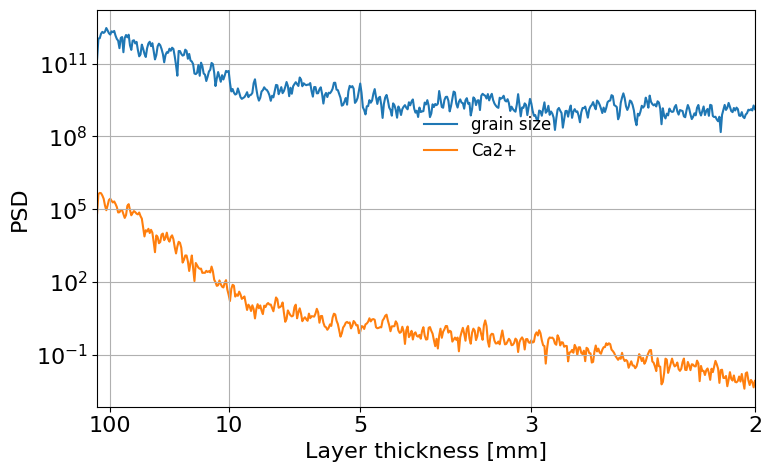

In [45]:
# Plot PSD of stadial xLASM grain sizes and Ca2+
fs = 1 # sampling frequency in [1/mm]
fig, ax = plt.subplots(figsize=(8, 5))
f, Pxx = welch(df_sizes_stadial["8.44"]["grain_size[px]"],fs,nperseg = 1000)
ax.semilogy(f, Pxx,label="grain size")
f, Pxx = welch(CFA_interp_stadial["Ca++ (ng/g)"],fs,nperseg = 1000)
ax.semilogy(f, Pxx,label="Ca2+",zorder=0)
ax.set_xlim(0.0001,0.5)
ax.set_xticks([1/100,0.1,0.2,0.33,0.5])
ax.set_xticklabels([100,int(1/0.1),int(1/0.2),int(1/0.33),int(1/0.5)])
ax.set_xlabel('Layer thickness [mm]')
ax.set_ylabel('PSD')
ax.legend(bbox_to_anchor= (0.7, 0.75), ncol=1,
            borderaxespad=0, frameon=False)
ax.grid()
fig.tight_layout()
fig.show()